## CNN 1D Implementation

Assurez-vous que vous avez déjà exécuté le notebook de :
- [la préparation du dataset](prepDataset.ipynb)

La structure de ce notebook est la suivante :
1. [Charger les datasets préparés par le notebook précédent](#generate-the-iterator-of-the-datasets)
2. [Définir le modèle CNN](#define-the-cnn-model)
3. Entraîner le modèle
4. Évaluer le modèle
5. Sauvegarder le modèle

In [89]:
import numpy as np
from joblib import load, dump
import time
import matplotlib.pyplot as plt
import tqdm
from tqdm import trange

## Générer l'itérateur des ensembles de données
Dans cette section, nous allons générer l'itérateur pour les ensembles de données. Un itérateur permet de parcourir les données par lots

In [90]:
np.random.seed(100)  

def dataloader(batch_size, workers=2):
    def create_batches(xdata, ylabel, batch_size):
        indices = np.arange(xdata.shape[0])
        np.random.shuffle(indices)
        xdata = xdata[indices]
        ylabel = ylabel[indices]
        
        num_batches = xdata.shape[0] // batch_size
        batches = []
        for i in range(num_batches):
            x_batch = xdata[i * batch_size:(i + 1) * batch_size]
            y_batch = ylabel[i * batch_size:(i + 1) * batch_size]
            batches.append((x_batch, y_batch))
        
        return batches
    
    train_xdata = load('files/trainX_512_10c')
    train_ylabel = load('files/trainY_512_10c')
    val_xdata = load('files/valX_512_10c')
    val_ylabel = load('files/valY_512_10c')
    test_xdata = load('files/testX_512_10c')
    test_ylabel = load('files/testY_512_10c')

    train_loader = create_batches(train_xdata, train_ylabel, batch_size)
    val_loader = create_batches(val_xdata, val_ylabel, batch_size)
    test_loader = create_batches(test_xdata, test_ylabel, batch_size)
    
    return train_loader, val_loader, test_loader

batch_size = 64
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break


51
14
7
(64, 512) (64,)


## Définir le modèle CNN

Dans cette partie, nous implémentons les composants du modèle CNN. Les composants nécessaires sont :

- Couches convolutionnelles
- Couches de pooling (AvgPool, MaxPool)
- Couches entièrement connectées (couche linéaire)
- Fonction ReLU
- Fonction de perte par entropie croisée
- Fonction Softmax (pour générer les probabilités)

Il est important de mentionner que dans chaque classe, les fonctions de propagation avant et arrière sont implémentées. Utiliser les bibliothèques `pytorch` rendrait certainement l'implémentation plus facile et plus efficace avec l'autograd. Cependant, dans ce notebook, comme requis dans les questions, seule la bibliothèque `numpy` sera utilisée.

Convolution layer

In [91]:
class Conv1D:
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = np.random.randn(output_channels, input_channels, kernel_size) * 0.1
        self.bias = np.zeros(output_channels)

    def forward(self, x):
        batch_size, _, seq_length = x.shape
        out_length = (seq_length + 2 * self.padding - self.kernel_size) // self.stride + 1
        out = np.zeros((batch_size, self.output_channels, out_length))

        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding)), mode='constant')

        for b in range(batch_size):
            for o in range(self.output_channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    out[b, o, i] = np.sum(padded_x[b, :, start:end] * self.weights[o]) + self.bias[o]
        
        self.cache = (x, out)
        return out

    def backward(self, dout, learning_rate=0.01):
        x, out = self.cache
        batch_size, _, seq_length = x.shape
        _, _, out_length = dout.shape

        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding)), mode='constant')
        dweights = np.zeros_like(self.weights)
        dbias = np.zeros_like(self.bias)
        dx = np.zeros_like(padded_x)

        for b in range(batch_size):
            for o in range(self.output_channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    dweights[o] += dout[b, o, i] * padded_x[b, :, start:end]
                    dbias[o] += dout[b, o, i]
                    dx[b, :, start:end] += dout[b, o, i] * self.weights[o]
        
        dx = dx[:, :, self.padding:-self.padding]

        self.weights -= learning_rate * dweights
        self.bias -= learning_rate * dbias

        return dx

ReLU layer

In [92]:
class ReLU:
    def forward(self, x):
        self.cache = x
        return np.maximum(0, x)

    def backward(self, dout, lr):
        x = self.cache
        dx = dout * (x > 0)
        return dx

In [93]:
class MaxPool1D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, channels, seq_length = x.shape
        out_length = (seq_length - self.kernel_size) // self.stride + 1
        out = np.zeros((batch_size, channels, out_length))

        self.cache = (x, out_length)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    out[b, c, i] = np.max(x[b, c, start:end])
        
        return out

    def backward(self, dout, lr):
        x, out_length = self.cache
        batch_size, channels, seq_length = x.shape
        dx = np.zeros_like(x)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    max_val = np.max(x[b, c, start:end])
                    dx[b, c, start:end] += (x[b, c, start:end] == max_val) * dout[b, c, i]

        return dx

In [94]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.1
        self.bias = np.zeros(output_dim)

    def forward(self, x):
        self.cache = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, dout, learning_rate=0.01):
        x = self.cache
        dweights = np.dot(x.T, dout)
        dbias = np.sum(dout, axis=0)
        dx = np.dot(dout, self.weights.T)

        self.weights -= learning_rate * dweights
        self.bias -= learning_rate * dbias

        return dx

In [95]:
class AvgPool1D:
    def forward(self, x):
        self.cache = x
        return np.mean(x, axis=-1, keepdims=True)

    def backward(self, dout):
        x = self.cache
        dx = dout * np.ones_like(x) / x.shape[-1]
        return dx

In [96]:
class CNN1DModel:
    def __init__(self, batch_size, input_channels, conv_archs, num_classes):
        self.batch_size = batch_size
        self.input_channels = input_channels
        self.conv_archs = conv_archs
        self.num_classes = num_classes
        self.layers = self.make_layers()
        self.avgpool = AvgPool1D()
        self.classifier = Linear(conv_archs[-1][-1], num_classes)
        
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_archs:
            for _ in range(num_convs):
                layers.append(Conv1D(self.input_channels, out_channels))
                layers.append(ReLU())
                self.input_channels = out_channels
            layers.append(MaxPool1D())
        return layers

    def forward(self, x):
        x = x.reshape(self.batch_size, 1, -1)
        for layer in self.layers:
            x = layer.forward(x)
        x = self.avgpool.forward(x)
        x = x.reshape(self.batch_size, -1)
        x = self.classifier.forward(x)
        # print(x.shape)
        return x

    def backward(self, dout, learning_rate=0.01):
        dout = self.classifier.backward(dout, learning_rate)
        dout = dout.reshape(self.batch_size, -1, 1)
        dout = self.avgpool.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout, learning_rate)

    def print_shapes(self):
        for i, layer in enumerate(self.layers):
            print(f"Layer {i}: {type(layer).__name__}, weights shape: {getattr(layer, 'weights', 'N/A')}")

In [97]:
def cross_entropy_loss(pred, target):
    """
    Compute the cross-entropy loss and its gradient.

    Parameters:
    pred (np.ndarray): Predicted probabilities (logits) of shape (batch_size, num_classes).
    target (np.ndarray): True labels of shape (batch_size,).

    Returns:
    tuple: Cross-entropy loss and gradient.
    """
    # Ensure predictions are probabilities (apply softmax)
    exps = np.exp(pred - np.max(pred, axis=1, keepdims=True))  # subtract max for numerical stability
    probs = exps / np.sum(exps, axis=1, keepdims=True)
    
    # One-hot encode the target labels
    batch_size = target.shape[0]
    num_classes = pred.shape[1]
    one_hot_target = np.zeros_like(pred)
    one_hot_target[np.arange(batch_size), target] = 1

    # Compute the cross-entropy loss
    log_probs = -np.log(probs[np.arange(batch_size), target])
    loss = np.sum(log_probs)

    # Compute the gradient of the loss
    grad = probs - one_hot_target

    return loss, grad



In [98]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

## Entraîner le modèle
Dans cette section, nous allons entraîner le modèle. 

$$
\color{red}
\text{-----------------------Veuillez lire ceci en premier !!!-----------------------}
$$

Il est très chronophage d'entraîner un modèle CNN. Nous avons testé et constaté que pour entraîner un modèle que nous avons conçu, pour une seule époque, le temps nécessaire pour exécuter seulement *4* lots coûterait environ 15 minutes.

Pour expliquer pourquoi c'est ainsi, le nombre de paramètres dans le modèle est de $615654$. Pour chaque lot, nous devons calculer la propagation avant et arrière. La propagation avant est calculée en multipliant l'entrée par la matrice de poids et en ajoutant le biais. La propagation arrière est calculée en multipliant le gradient de la fonction de perte par la matrice de poids. Cela est fait pour chaque couche du modèle. La complexité temporelle de cette opération est de $O(n^2)$ où $n$ est le nombre de paramètres dans le modèle. C'est pourquoi il est si chronophage d'entraîner un modèle avec un grand nombre de paramètres.

Ci-dessous, vous pouvez essayer par vous-même d'exécuter la fonction `model_train` et observer comment elle fonctionne.

Nous avons enregistré les résultats de la sortie de cette fonction en la faisant fonctionner pendant plus de 40 heures. Les valeurs ont été enregistrées dans les fichiers respectivement nommés `tl.npy`, `vl.npy`, `ta.npy`, et `va.npy`. Vous pouvez charger ces fichiers et tracer les résultats. Ces valeurs sont respectivement la perte d'entraînement, la perte de validation, la précision d'entraînement et la précision de validation.

![image](files/image.png)

In [ ]:
batch_size = 64
epochs = 100

train_loader, val_loader, test_loader = dataloader(batch_size)

model = CNN1DModel(batch_size, input_channels=1, conv_archs=[(2, 128)], num_classes=10)
def optimizer():
    return None

loss_function = cross_entropy_loss

model_train(batch_size, epochs, model, None, loss_function, train_loader, val_loader)

## Resultats

In [100]:
# import scienceplots

# plt.style.use(['science', 'ieee'])

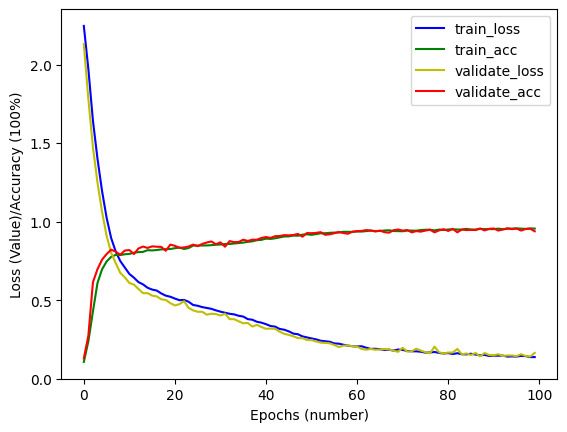

In [101]:
tl = np.load("files/tl.npy")
ta = np.load("files/ta.npy")
vl = np.load("files/vl.npy")
va = np.load("files/va.npy")


plt.xlabel('Epochs (number)')
plt.ylabel('Loss (Value)/Accuracy (100%)')
plt.plot(tl, color='b', label='train_loss')
plt.plot(ta, color='g', label='train_acc')
plt.plot(vl, color='y', label='validate_loss')
plt.plot(va, color='r', label='validate_acc')
plt.legend()

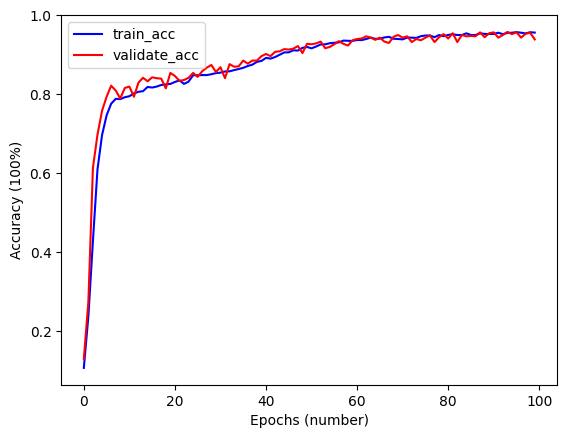

In [102]:
vl = np.load("files/vl.npy")
va = np.load("files/va.npy")
plt.xlabel('Epochs (number)')
plt.ylabel('Accuracy (100%)')
plt.plot(ta, color='b', label='train_acc')
plt.plot(va, color='r', label='validate_acc')
plt.legend()

In [103]:
print('Accuracy pourcentage: (test / validation)')
print(ta[-1]), print(va[-1])

Accuracy pourcentage: (test / validation)
0.9558823529411765
0.9386160714285714


(None, None)

## Amélioration : CNN 2D !!